In [1]:
#Importing necessary packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

from scipy.stats import randint
import re

import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

pd.set_option('display.max_colwidth',None)

In [2]:
#Loading Dataset
data = pd.read_csv('Context.csv')
data = data.rename(columns = {'Context/Topic': 'topic'})#renaming column 'Context/Topic' to 'topic'
#making a copy of dataframe
df = data.copy()
df.head()

,Text,topic
0,The eternal mystique of Goldman Sachs,Politics
1,Either you don't care enough to actually tell me how u feel and I am a dumbass thinking we could get again work on this or I am completely fucked in the head because of all your mind game shit over the years to where I say things and do things because I know what you used to say or what you used to think and I am all over the place tryi g to be sure how not to upset u or make you think I am some low life and pathetic.,Love
2,I am such an IDIOT.,Heavy Emotion
3,"While lifting weights on Friday and doing bent over rows, I felt a sharp pain in my lower back. Some would say I threw it out and I had this happen one other time about 6 months ago. Dropped to my knees and was sore for the rest of the day. Overnight, it just became terrible. Every time my body wanted to move, I woke everybody in the room up with moans of pain (wife, dog, cats).",Health
4,Something's watching me,Animals


In [3]:
df.loc[0]

Text     The eternal mystique of Goldman Sachs
topic                                 Politics
Name: 0, dtype: object

In [3]:
#checking basic summary
print("Size of dataframe is : {}".format(df.size))
print("Number and list of unique topics are : {} / {}".format(df['topic'].nunique(), df['topic'].unique()))

Size of dataframe is : 62772
Number and list of unique topics are : 11 / ['Politics' 'Love' 'Heavy Emotion' 'Health' 'Animals' 'Science' 'Joke'
 'Compliment' 'Religion' 'Self' 'Education']


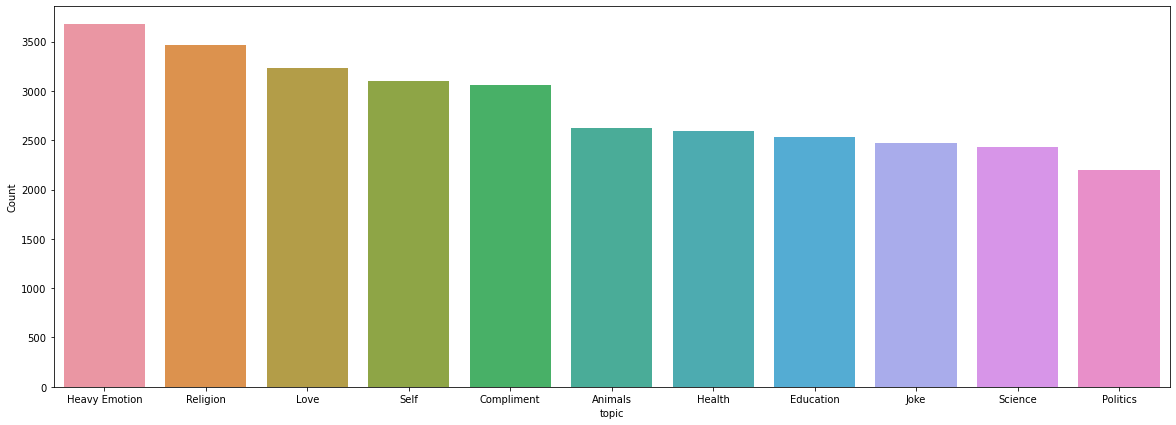

In [4]:
#Summary statistics on 'Topics'
target_summary = df.groupby(['topic']).count().reset_index().sort_values('Text', ascending=False)
target_summary = target_summary.reset_index(drop=True)
#Plot Bar chart
# Figure Size
fig = plt.figure(figsize =(20, 7))

# Horizontal Bar Plot
#plt.bar(target_summary['Context/Topic'], target_summary['Text'])
sns.barplot(x='topic', y='Text', data=target_summary )

plt.ylabel('Count')

# Show Plot
plt.show()

#Dataframe
#target_summary

In [5]:
#Checking for null values
print(df.isnull().sum())
print('There are no null values present')

Text     0
topic    0
dtype: int64
There are no null values present


In [6]:
#Finding length of each text
data1 = df.copy()
data1['Len_Text'] = data1['Text'].apply(lambda x: len(x.split(' ')))
data1.head()

,Text,topic,Len_Text
0,The eternal mystique of Goldman Sachs,Politics,6
1,Either you don't care enough to actually tell me how u feel and I am a dumbass thinking we could get again work on this or I am completely fucked in the head because of all your mind game shit over the years to where I say things and do things because I know what you used to say or what you used to think and I am all over the place tryi g to be sure how not to upset u or make you think I am some low life and pathetic.,Love,94
2,I am such an IDIOT.,Heavy Emotion,5
3,"While lifting weights on Friday and doing bent over rows, I felt a sharp pain in my lower back. Some would say I threw it out and I had this happen one other time about 6 months ago. Dropped to my knees and was sore for the rest of the day. Overnight, it just became terrible. Every time my body wanted to move, I woke everybody in the room up with moans of pain (wife, dog, cats).",Health,81
4,Something's watching me,Animals,3


In [7]:
#checking for any duplicate rows
duplicate = df[df.duplicated()]
print("Number of duplicate rows are: {}".format(len(duplicate)))

#checking duplicate rows on Text column
duplicates_text = df[df['Text'].duplicated()]
print("Number of duplicate rows in 'Text' columns are: {}".format(len(duplicates_text)))

Number of duplicate rows are: 0
Number of duplicate rows in 'Text' columns are: 0


In [8]:
#Checking the count of words in Text column
print("Total count of words in 'Text' column : {}".format(df['Text'].apply(lambda x: len(x.split(' '))).sum()))

Total count of words in 'Text' column : 769223


# Data Pre-processing

In [46]:
#pattern for removing emoji
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
#pattern to remove special_char
special_char = re.compile('[/(){}\[\]\|@",;.-]')

#Method to clean data

def clean_data(text):
    #lower text
    text = text.lower()
    #removing emojis
    text = emoji_pattern.sub(' ', text)
    #removing special characters
    text = special_char.sub(' ', text)   
    #remove whitespaces
    text = text.strip()
    return text

In [11]:
#clean text
df['Text'] = df['Text'].apply(clean_data)

In [12]:
#Encoding the labels
possible_labels = df.topic.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Politics': 0,
 'Love': 1,
 'Heavy Emotion': 2,
 'Health': 3,
 'Animals': 4,
 'Science': 5,
 'Joke': 6,
 'Compliment': 7,
 'Religion': 8,
 'Self': 9,
 'Education': 10}

In [13]:
#Applying the encoding to 'topic' 
df['category_id'] = df.topic.replace(label_dict)
df.head()

,Text,topic,category_id
0,the eternal mystique of goldman sachs,Politics,0
1,either you don't care enough to actually tell me how u feel and i am a dumbass thinking we could get again work on this or i am completely fucked in the head because of all your mind game shit over the years to where i say things and do things because i know what you used to say or what you used to think and i am all over the place tryi g to be sure how not to upset u or make you think i am some low life and pathetic,Love,1
2,i am such an idiot,Heavy Emotion,2
3,while lifting weights on friday and doing bent over rows i felt a sharp pain in my lower back some would say i threw it out and i had this happen one other time about 6 months ago dropped to my knees and was sore for the rest of the day overnight it just became terrible every time my body wanted to move i woke everybody in the room up with moans of pain wife dog cats,Health,3
4,something's watching me,Animals,4


In [14]:
#Making a copy of dataframe
cleaned_df = df.copy()
cleaned_df.head()

,Text,topic,category_id
0,the eternal mystique of goldman sachs,Politics,0
1,either you don't care enough to actually tell me how u feel and i am a dumbass thinking we could get again work on this or i am completely fucked in the head because of all your mind game shit over the years to where i say things and do things because i know what you used to say or what you used to think and i am all over the place tryi g to be sure how not to upset u or make you think i am some low life and pathetic,Love,1
2,i am such an idiot,Heavy Emotion,2
3,while lifting weights on friday and doing bent over rows i felt a sharp pain in my lower back some would say i threw it out and i had this happen one other time about 6 months ago dropped to my knees and was sore for the rest of the day overnight it just became terrible every time my body wanted to move i woke everybody in the room up with moans of pain wife dog cats,Health,3
4,something's watching me,Animals,4


In [16]:
#Initializing TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(cleaned_df.Text).toarray()

labels = cleaned_df.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 31386 text is represented by 11843 features (TF-IDF score of unigrams and bigrams)


In [19]:
# Dictionaries for future use
category_id_df = cleaned_df[['topic', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'topic']].values)

In [22]:
# Finding the three most correlated terms with each of the topic categories
N = 3
for topic, category_id in sorted(category_to_id.items()):
    
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(topic))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Animals:
  * Most Correlated Unigrams are: animal, dog, animals
  * Most Correlated Bigrams are: animals world, wild animals, critter science

==> Compliment:
  * Most Correlated Unigrams are: congratulations, proud, congrats
  * Most Correlated Bigrams are: good luck, great job, good job

==> Education:
  * Most Correlated Unigrams are: training, noida, school
  * Most Correlated Bigrams are: training center, noida sector, training noida

==> Health:
  * Most Correlated Unigrams are: treatment, ad_1, health
  * Most Correlated Bigrams are: health benefits, covid 19, weight loss

==> Heavy Emotion:
  * Most Correlated Unigrams are: hate, fuck, fucking
  * Most Correlated Bigrams are: need vent, just want, feel like

==> Joke:
  * Most Correlated Unigrams are: replies, asks, says
  * Most Correlated Bigrams are: man says, guy says, walks bar

==> Love:
  * Most Correlated Unigrams are: loved, relationship, love
  * Most Correlated Bigrams are: fell love, love love, fall love

==> P

In [23]:
#Splitting data into train and test

X = cleaned_df['Text'] # Collection of text
y = cleaned_df['category_id'] # Target or the labels we want to predict (i.e., the 11 different topics)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

# Model Training

In [18]:
#List of models to train
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/shreyasnanaware/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shreyasnanaware/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [19]:
#Model Comparision
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc.sort_values('Mean Accuracy', ascending=False)

,Mean Accuracy,Standard deviation
model_name,,
LogisticRegression,0.640094,0.003632
MultinomialNB,0.627923,0.002389
LinearSVC,0.627509,0.001133
RandomForestClassifier,0.294781,0.008851


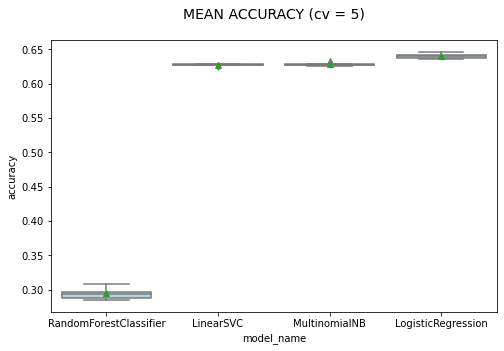

In [20]:
#Graph to show accuracy
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

# Model Evaluation

In [24]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               cleaned_df.index, test_size=0.25, 
                                                               random_state=1)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/Users/shreyasnanaware/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= cleaned_df['topic'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

     Politics       0.84      0.76      0.80       556
         Love       0.57      0.57      0.57       789
Heavy Emotion       0.53      0.61      0.57       935
       Health       0.65      0.60      0.62       671
      Animals       0.77      0.70      0.73       645
      Science       0.60      0.59      0.59       603
         Joke       0.75      0.65      0.69       613
   Compliment       0.70      0.63      0.67       738
     Religion       0.70      0.69      0.69       899
         Self       0.42      0.57      0.48       757
    Education       0.74      0.64      0.68       641

     accuracy                           0.63      7847
    macro avg       0.66      0.64      0.65      7847
 weighted avg       0.65      0.63      0.64      7847



Text(0.5, 1.0, 'CONFUSION MATRIX - LogisticRegression\n')

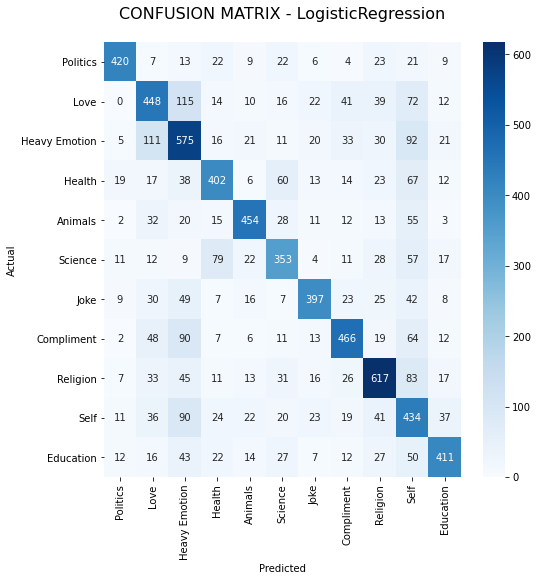

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.topic.values, 
            yticklabels=category_id_df.topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16)

In [28]:
#Misclassified complaints
temp_dict = {}
for predicted in category_id_df.category_id:
    
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(cleaned_df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['topic', 
                                                                'Text']])
            temp_dict[id_to_category[actual] + 'Predictedas_' + id_to_category[predicted]] = cleaned_df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['topic', 
                                                                'Text']]
            
            print('')

'Heavy Emotion' predicted as 'Love' : 111 examples.


,topic,Text
5518,Heavy Emotion,i have maybe 4 real friends all living far away with different jobs schedules i'm alone almost everyday finding someone is complicated especially with how most of my family is conservative and i wouldn't even be able to bring him home my relationships always start online and end in the other person cheating on me or long distance that falls apart i feel like i don't have anyone that really cares about me besides a few family members i so so want that close connection with someone and it's making me so stupid
5188,Heavy Emotion,i'm 26 and never had girlfriend or even been kissed maybe i should give up and accept i'm not ever gonna be loved and that nobody cares that no woman loves me or ever will
13367,Heavy Emotion,found my boyfriend installed tinder again!
15160,Heavy Emotion,this seems to be dragging on longer that i thought it would sorry to anyone trying to read this
25068,Heavy Emotion,i got cheated on for the second time my life has fallen apart
...,...,...
25292,Heavy Emotion,i made a mistake and nobody will forgive me
25992,Heavy Emotion,a letter to me ex
10185,Heavy Emotion,jewish ex gf with depression broke up w me what do you think
1425,Heavy Emotion,"""you're worthless"""



'Animals' predicted as 'Love' : 32 examples.


,topic,Text
2788,Animals,i love cows :o
22794,Animals,puppies dressed as disney characters make my heart a'splode
6099,Animals,very interesting eyes!
266,Animals,taa terapia assistida por cães serra da estrela na appacdm do fundão
21827,Animals,things like this just warm my heart
20367,Animals,my girlfriend started an etsy shop up for these awesome pet pawtraits go show her some love
15372,Animals,heart aching images of a demented koala after his home has been cut down
14024,Animals,wake me up inside
28486,Animals,i know this isn't really an aww but this was my dog and i in 2006 today i had to hold him during his last breath i just wanted to say thank you for the memories and ill see you soon sparky
22143,Animals,then i remembered today was gardening day and the gardeners would come with the leaf-blowers and scare it to death so i got a towel and was going to go out bundle it up and put it in the garage until it was safe



'Joke' predicted as 'Love' : 30 examples.


,topic,Text
25943,Joke,it would have to be set up something like this
10349,Joke,88 when they say 'will that be all?' snicker and say 'we ll find out \nwon't we?'
11914,Joke,"he's never lost a match because of this ""pretzel"" hold he has whatever you do don't let him get you in this hold! if he does you're finished!"""
761,Joke,arriving at the best suit-maker in town the tailor tells the man he's so good that he doesn't need a tape measure to know his sizes
15979,Joke,"when she got to ""r"" once again johnny is the only one with his hand up she can't think of any bad words starting with ""r"" so she calls on him"
10418,Joke,"my girlfriend came out of the showershe said ""i shaved my pussy you know what that means?"""
24750,Joke,what do you call a kid with three eyes?
11101,Joke,moving closer he slipped his arm around her shoulder and added
2463,Joke,79 put them on hold come back on the line and say\n to yourself 'i sure wish clinton would learn to make\n decisions by himself '
12235,Joke,"""honey it's your 65th birthday come upstairs and make love to me """



'Compliment' predicted as 'Love' : 48 examples.


,topic,Text
24168,Compliment,que? xd
17521,Compliment,thanks! and i took her to my grandpas pond an extremely important place to me and when we got there i had a table set up with roses a bottle of wine and glasses on a table then we drank wine on the pier and relaxed i told her i wanted to take a picture of us so i set up my camera like it was on timer but it was on video and then i got on one knee and proposed it might not sound perfect but it was to us!
26351,Compliment,they is probably meant as a gender neutral pronoun
11314,Compliment,nice! usually i spend the morning rehearsing everything i am going to say but when the dr asks me how are things i forget everything and just go 'all good!'
11650,Compliment,lies
24232,Compliment,lots of love and keep up dude!
2462,Compliment,i’m trying to look forward :
33,Compliment,nice i didn’t know that was a thing but i love cream cheese!!
26075,Compliment,i’m being honest
9371,Compliment,i took her to my grandpas pond an extremely important place to me and when we got there i had a table set up with roses a bottle of wine and glasses on a table then we drank wine on the pier and relaxed i told her i wanted to take a picture of us so i set up my camera like it was on timer but it was on video and then i got on one knee and proposed it might not sound perfect but it was to us!



'Religion' predicted as 'Love' : 33 examples.


,topic,Text
1246,Religion,"""he maketh me to lie down in green pastures he leadeth me besides the still waters "" what does that mean?"
24888,Religion,his family structure is very unconventional and he and the mom are getting a divorce after 20+ years the daughter is very musical very creative loves rupaul said that she wanted to have her pronoun be 'they' but i in my limited view as an uncle think that is just what her peer group is doing these days i don't think she has ever been in a 'romantic' relationship with anyone of any gender
29121,Religion,ever since i've kinda felt empty it's kinda like i died metaphorically i know i talk about it a lot in the spiritual sense but it honestly feels like a lot has died
21622,Religion,who is this? i've been told that i could be arrested and executed if i say anything bad about him
1098,Religion,o que diz a deus?
29055,Religion,"what do they mean? like tasting ""bodyjuices"" or what?"
19412,Religion,we need to remember that there is always a chance that we haven’t seen every possibility…and that what we know in this world is only what we’ve witnessed and experienced so far…
28391,Religion,love transits report
5531,Religion,i know this sounds weird but my mind is constantly asking deep questions about the universe about death how does one person stop feeling anything indefinitely? scary
11637,Religion,i mean can you trace back your ancestry in any way?



'Self' predicted as 'Love' : 36 examples.


,topic,Text
28621,Self,after seeing such a fantastic movie i would love to know what it was like filming on set and also playing guitar at 80 mph while blindfolded the guitar guy was one of the most iconic characters i've seen in a while
22504,Self,i am a want-to-be youtuber who has millions of ideas but becomes awkward on camera and feels self-centered
17755,Self,\-comfortable feeling
3015,Self,afterwards we review the incidents to tally up broken laws inappropriate uses of force things that would cause public outrage we backseat them just like the media and public would
5135,Self,long time lurker first time poster here
10220,Self,19m i’m looking to make new friends after a recent break up
10709,Self,2 have never gotten into any of those fights 3 was friends with almost all the troublemakers and that's why i know all the hot tea
23352,Self,quick facts:
9679,Self,saw a few of these and decided it looked fun
2802,Self,i suppose friendship from cult was like sisters and brothers i enjoyed that we shared everything



'Love' predicted as 'Heavy Emotion' : 115 examples.


,topic,Text
10956,Love,yesterday someone was crying for me &amp today i’m crying for someone !!
5134,Love,i can’t stop looking at you
10371,Love,i have a new girlfriend now i am finally taking back my life and its just now that you come back to me not obviously it started as flirty snapchat messages and slight slight smiles at school but now you have moved onto complaining about liking someone who you have no chance with on your story just minutes after connecting with me over yet another mutual interest we coincidentally share you are on the way to tearing my life and *healthy* new relationship apart again you have no right to do this to me you don't deserve me if i took you back it would just end like last time and to go through that again would kill me
11066,Love,i hate this feelingi’ve been coming on 3 months without being in the same home as my ex her 18 year old son and our daughter and i hate every second of it it hurts seeing that we can get along as adults for the sake of our children but my heart hurts every time i see her during my exchanges i try so hard to show her i’m here for them by paying our water internet and furniture plus tv bills all while trying to give her money on he side when i can when i see her i hold back my tears and what i want to say i love this woman so much it’s driving me crazy so much i can’t focus on female friends who have “feelings” for me i just want her back in my life a family and partner who i’d dedicate myself to forever now since i ran from it while we lived together for 6 years what can i do if i can’t say it directly to her?
2252,Love,a month later he found a new girlfriend and blocked me off everything
...,...,...
21903,Love,as the excitement of telling each one
8723,Love,it’s been rocky the past few months because of quarantine every day i feel like i just make her upset over the dumbest shit every day there’s been something to make her upset every day and i’m trying to not do that? i’m trying so hard
13678,Love,i just want to love her! i miss her more than i can believe! i want her back! bur she f*cking hurt mei just needed to vent this man i miss her so much i just want to cry into her tiny arms and be kissed to sleep but i can’t
25641,Love,it is frustrating to date other people when that human exists in your peripheral you compare each new prospective mate to them and you hate when you catch yourself doing it you feel guilty and end up leaving the new partner because of it they have made it crystal clear that they do not want to enter into a relationship with anyone this you know for sure so you are friends



'Health' predicted as 'Heavy Emotion' : 38 examples.


,topic,Text
17811,Health,what steps would i have to take to stop eating entirely?
25699,Health,habits of highly positive people
27831,Health,ideally once i'm concerned about an issue the latency should be fast like a 0 5-1 days and i should be able to make as much time for an apt as required
10244,Health,there is the pic it's poop so nsfw i'm scared because this has never happened before the consistency is like snot like a sneeze it happened yesterday last night and again tonight 2 days ago i finished my antibiotic i have a feeling that it might be the cause? i'm a little scared about it tomorrow is a holiday so i can't visit the doctor can i get some advice?
21082,Health,* more pains headaches ears pulsing armpits feel painful legs ache especially on my left side
20929,Health,i'm just reposting the advice here in case it could be useful for someone in the future apparently it's a very rare condition a search of reddit only turned up one other post
25470,Health,i've recently been having this problem that has got worse over the last few years when i am tired or out drinking my left eyelid goes slightly closed it used not to be noticeable but now unless i get a full sleep in i'll get it the next day and i am beginning to get self conscious about it
2055,Health,i don't sleep around so this can't be an sti but i was thinking it could be epididymitis regardless
27213,Health,i know before i've been advised to just see a doctor because taking advice off the internet isn't wise doctors are clueless though and i have no insurance i'm currently selling assets and purchasing insurance but in getting worse fast
21568,Health,let me add my mom eats poorly because she hates to cook so i suppose vitamins as a rule will do her some good but i am talking about some vitamin combination that might be of real help



'Animals' predicted as 'Heavy Emotion' : 20 examples.


,topic,Text
30435,Animals,my dog killed a skunk tonight &amp i feel like shit about it
7373,Animals,they're basically the cutest things ever and i was surprised to see how few people knew they were even a thing :
25816,Animals,nobody cares who i was until i put on the mask
15483,Animals,my wife and i have decided to get a puppy she is a 3 month old saint bernard and we have had her for just under 2 weeks now at first she was shy and quite but has broken out of that and she is successfully crate trained as of 2 days ago the biggest issue is was the fact that she wouldn't eat or drink anything we figured it was just because it's a brand new environment for her and she must feel slightly depressed and we were right the second night we had her she ate two whole cans of dog food and drank quite a bit of water so i immediately note down the food and pickup a pack of it for her she since has touched that food and seems completely uninterested in it i have tried a variety of different puppy and adult foods and it seems like every option we provide for her is a miss
22837,Animals,this turtle is pissed
31363,Animals,can someone please help me or give me advice i really need to know what to do i'm so scared and this kitten means the world to me i don't know what i'd do if she passed away has anyone had this happen before any advice is welcomed and thanked i really need this!
57,Animals,bear family to be killed because dumb humans wouldn't leave them alone
5262,Animals,beans just wants a drama free relationship
31190,Animals,do not pound your chest in front of a silverback
9825,Animals,well imgur wasn't much help maybe redditors can help with naming a big ass bunny sorry if there are any problems with the album it's my first time posting



'Joke' predicted as 'Heavy Emotion' : 49 examples.


,topic,Text
3191,Joke,you don’t need a parachute to go skydiving you need a parachute to go skydiving twice
26960,Joke,"geologist: ""yeah they're just fucking rocks ""\nwhat would you call a chinese based arm of isis?\nricesis\ni've made the front page 5 times!\nthe girls on r creepypms are really mean and don't understand the p means private \nwhat do you call a black and white bra?\nzebra\ni'm so horny \n even the crack of dawn looks good \nspace windows and bob fixing it"
16906,Joke,'well you don't give me enough housekeeping money to afford any '
24471,Joke,"""don't be stupid "" said the third pollock ""you should know that is christmas easter is the time of year when jesus died for our sins and was put behind a boulder then in three days he pushed the boulder out of the way stepped outside saw his shadow and ran back inside shouting six more weeks of winter ""\nanxious to impress\nian was very anxious to impress his girlfriend's parents so he was particularly pleased when they invited him round for dinner"
3329,Joke,"""sure tell me her name and i'll let you know if i've slept with her """
1174,Joke,76 learn to play a blues riff on the harmonica \n stop talking at regular intervals to play it
15668,Joke,my neighbor knocked on my door this morning at 2:30 am!luckily for him i was still up playing my drums
9370,Joke,i've decided to quit my job as a personal trainer because the weights are too heavy i just handed in my too weak notice
19644,Joke,“are you sure this is necessary?”
5691,Joke,4 bandage left foot



'Compliment' predicted as 'Heavy Emotion' : 90 examples.


,topic,Text
21463,Compliment,meanwhile im trying to do my first one
15199,Compliment,i want this on my wall
11108,Compliment,no i have thyroid problems and severe panic and anxiety makes my chest hurt super bad
22907,Compliment,ofc no shame just a thing ive been trying to do
8126,Compliment,epic! try to keep stealing smol things so that stores don’t crash cuz that would be bad
...,...,...
19973,Compliment,i agree completely i've actually been wanting to write my own music so that i can just get a lot of things off my chest and have a good creative outlet i have a bunch of ideas all written out on my phone but i just don't have access to any music making software guess i just need to start working harder to get where i want to be
12373,Compliment,secondly and much less importantly your english is better than that of most native speakers myself included!
26545,Compliment,"just have to chime in and say that while you were ""a trooper"" for having painful sex *no one should power through painful sex* while it seems it didn't for you it can for many women cause an aversion to sex that is *very* hard to shake if ever it's recommended that whatever act is painful like piv be taken off the table entirely until the issue is resolved and other sex acts substituted it can require some creativity but that's better than potentially destroying one's sex life by forcing oneself to have sex that hurts"
18039,Compliment,i'm pretty out of shape and got my gym-goer friend to go with me it was a lot of fun the equipment and the people were intimidating at first but as soon as you start exercising you forget all about it



'Religion' predicted as 'Heavy Emotion' : 45 examples.


,topic,Text
938,Religion,appunti biografici su don tonino bello
29421,Religion,who is the figure on this pendant?
14753,Religion,i have a lot more worries but if i wrote them all out i’d be here all night i know that part of conversation is engaging in the jewish community and talking to other people but i’m scared to talk to my jewish friends about it bc i don’t want to seem disrespectful there’s my grandma on my dads side i could talk to but i don’t want to disappoint her if i don’t go through with it and besides i’ll have to wait a few years until i’ve moved out of my parents house to convert because of my mom finds out she’ll flay me alive but then is that a bad sign that i’m willing to put off making a covenant with god because i’m scared of mere parental disapproval?
14367,Religion,note to journalists: when reporting on charismatics please try to get details right
5886,Religion,i've been trying to hard to find something to believe in but due to my anxiety disorder i don't want to be wrong and listen to my head
17539,Religion,i'm about to do shadow work because i feel called to do it but don't feel like i should go at this alone if that makes sense
6933,Religion,don't kill me
8232,Religion,instead of being sad your whole life over the fact that your condition can never go away because those doctors told you there’s a 100% chance it won’t go away based on the fact that they’ve never seen it go away before … instead of huffing and puffing in the corner because you want to run freely but you can’t… instead of spending the little amount of time that we all have on this earth miserably…
20709,Religion,he’s not wrong
7771,Religion,they had gotten fed up with paying tribute for their protection and decided they didn’t need the bodyguard services of chedorlaomer and his allies the other three kings



'Self' predicted as 'Heavy Emotion' : 90 examples.


,topic,Text
21940,Self,i do think a lot like the 40 year old virgin in that i respect women enough to mostly stay away from them as bad as that movie is for that character he at least had opportunities with women and just blew it i’ve never had a girl alone in a room with any situation like that i admit i also really don’t understand women either as i have seen skinny girls date over weight guys and good looking nice girls date assholes who can barely hold down a job so i really don’t know what to do i’m sick and tired of always seeing on social media girls complain about never finding a good guy when they continue to date guys who treat them bad and i’m in my situation i’ve tried online dating tinder you name it i’ve had a few conversations and matches on tinder but none have ever led to a date
20338,Self,i'm 28 f single my entire life and never really been in a relationship
28543,Self,* i'm very bad at online dating and hate pretty much everything about it
10974,Self,she had stepped out for a smoke during her break he had their car and picked her up and took her to their apartment up the street three-ish days later he reported it from the store phone at his other job
10979,Self,i just lost my job and i now have a plan to spend the rest of the money i have left to get blackout drunk and then blow my brains out in a secluded location
...,...,...
14160,Self,i'm going to jail in 4 hours
10680,Self,i have severe seasonal depression i'm fine in the summer so really !
28844,Self,i’m leaving reddit for a while so i can get ready to follow nickelback around on tour !
5825,Self,so my friend jen and i are having one of our grand life talks and the subject of casual encounters with men seems to be the topic of the evening we've already covered that we are the raddest dudes in women's bodies i e we play video games obsess over pizza and whiskey we don't get easily attached or rather we generally don't give a shit unless there is a mutual connection so can someone tell us what we are doing wrong? why are men seemingly into us one moment and suddenly freeze off and are never heard from again? this remains a mystery to us and we are genuinely curious as to what dudes have to say about this



'Education' predicted as 'Heavy Emotion' : 43 examples.


,topic,Text
31322,Education,can i just keep going to school?i am about to graduate with a bsc in mechanical engineering and i have a job lined up which is a long committment and i am excited about i want to go back and do my masters later but right now before i do this job is kind of pointless since it will not be utilized and will be worthless at the end of the contract
12941,Education,my mom is yelling at me for getting a 75 in one of my subjects and is now comparing me to my sister i get this talk everytime i don’t come home with a 90 or higher i’m sick of it and idk what to do
3230,Education,i’m upset rn and want to get this off my chest
10300,Education,“you’d walk through the halls and it’s a lot of old white men ” ms varuolo-clarke said still she pushed forward and began her ph d in atmospheric science at columbia university last year
4802,Education,can anyone relate
26579,Education,if you hate your work it makes you get sloppier with it making you hate it more and eventually making you not want to do it it's such a strange problem the fact that your own mind would actively work against you
23594,Education,basically in my old school i had like no friends and it was horrible i have moved to a new school and have made friends but i dont think they like me we never really have conversations and when im with them it doesnt feel like im really with them today we were in the library and they just left without telling me idk what to do because if i leave them i'll have no friends
18412,Education,for next year my schedule has:
22567,Education,any advice or ways you can help me in this situation? i don't want a suspension on my record
22231,Education,i feel like a failure



'Politics' predicted as 'Health' : 22 examples.


,topic,Text
29916,Politics,biden cancer nonprofit paid its top execs millions it spent little to eradicate cancer
3402,Politics,fda restricts battelle to sterilizing 10k ppe masks per day at columbus oh location despite capacity to sterilize up to 160k per day across multiple locations
16914,Politics,house committee bars publication of reports by congressional research service
13226,Politics,idaho is rationing health care statewide as it struggles to cope with covid-19
11695,Politics,exports prop up japan growth u s protectionist risks loom
18729,Politics,the alt-right thrives in opposition what happens now it's the establishment?
24621,Politics,g7 ministers spike joint statement on covid-19 after u s demands it be called 'wuhan virus'
14403,Politics,analysis of time spent by topic during whitehouse covid-19 briefings
5754,Politics,oklahoma to resume executions 9 months after a lethal injection went awry
2968,Politics,los angeles raises minimum wage to $15



'Science' predicted as 'Health' : 79 examples.


,topic,Text
18322,Science,hgh injections: a worth supplement - blogger
13106,Science,natural health news by dr mark rosenberg
8367,Science,largest ever study of acceptance and commitment therapy a cognitive therapy used by psychologists found that just five sessions of psychoeducation for 28 930 primary care health workers led to a 21% reduction in sick leave over 2 years full text in link
5206,Science,evidence emerges that measles outbreaks are deliberately encouraged by big pharma to ignite vaccine hysteria
5126,Science,young people in liberal states use more cannabis but have lower rates of dependence
...,...,...
25229,Science,hajbeültetés nőknek klinikánkon képzett tapasztalt orvosok végzik el a beavatkozást
6557,Science,'exercise hormone' irisin is more myth than reality
10143,Science,re-opening indiana schools did contribute to spreading covid-19 but less than researchers expected
16945,Science,actual problems of applied sciences journal world



'Self' predicted as 'Health' : 24 examples.


,topic,Text
28524,Self,my name is chris and i used to weigh 550lbs in 3 years i was able to lose over 280lbs with no diet scams or weight loss programs ask me anything!
28039,Self,operate at the same wavelength as 5g internet also causes cancer
25062,Self,i was eating rainbow nerds 5 of them dropped and they were all pink this must be a sign
18305,Self,nobody takes covid-19 seriously where i live
27989,Self,i also rented rooms that didn't belong to me for a few weeks i owned a market garden
14579,Self,i’m a massage therapist !
6085,Self,i am a registered dietitian answering common on how to eat healthy while practicing social distancing !
20431,Self,please take my mind of the pain :
28774,Self,i am 18 and i have heds a chronic disease and live with pain and constant fatigue every day
30845,Self,i’ve failed at a lot of things in life but at 29 i knew i had to lose weight or die at 50 i’ve struggled with being obese my entire life and thought there was nothing i could 3 years ago i got very serious and started doing a lot of research online the pages on reddit and started taking the advice of others i still have about 70 lbs to goal weight but this is the farthest i’ve ever come with losing weight and keeping it off my buddy suggested i do an so here i am



'Education' predicted as 'Health' : 22 examples.


,topic,Text
3092,Education,preliminary schedule
17507,Education,medcram on deviantart - get updates
13667,Education,बिना अंग्रेजी दवाई करे घंटो तक चुदाई शानदार नुस्खा । increase your
8617,Education,học bổng du học
23157,Education,coronavirus helpers: the real heroes
4514,Education,own life: buy one of the best novels online at affordable prices
17693,Education,several benefits from ccnp security certification
31277,Education,detailed tips are available in my some videos #sthash rb0shcbt dpbs which i developed after lots of research and experience
23827,Education,choose medical administration course for a bright future
27655,Education,why is cipa so dangerous?



'Heavy Emotion' predicted as 'Animals' : 21 examples.


,topic,Text
17683,Heavy Emotion,when i'm failing myself
19290,Heavy Emotion,"then my so takes a pic of the poorly opened box and shows it to his buddy via snapchat he captioned it with something to the effect of ""how my gf opens a box of cue tips"""
29919,Heavy Emotion,my baby misses me
4246,Heavy Emotion,why must you annoy the piss outta meee!!!!
22917,Heavy Emotion,what a morning
14561,Heavy Emotion,i look the same as i do on my profile all my pics are recent &lt 6 months old i may even look thinner than in the photos honestly
27206,Heavy Emotion,no snow day
27485,Heavy Emotion,i am not a person i am rage i am a tree bitter and poisonous i am ivy stepped on constantly i am kudzu all encompassing and yet only noticed when i'm a problem
18869,Heavy Emotion,someone please remind me to never go outside again
14096,Heavy Emotion,staring into the pit of madness should i jump in?



'Science' predicted as 'Animals' : 22 examples.


,topic,Text
15474,Science,how to download guard locked facebook profile picture - define programming
7681,Science,secrets of the animals that dive deep into the ocean with graphic
12571,Science,bescientific org: element of surprise helps babies learn
13757,Science,video: the winner of 2011 nikon small world in motion
23266,Science,endangered dusky gopher frogs released into the wild in jackson county : science : tech times
1603,Science,a shark swallowing another shark whole
7565,Science,tracking wild peanut genes to improve crop resilience
1468,Science,bone eating worms dined on marine reptile carcasses
30579,Science,how extinction changed the coyote
18655,Science,multiple occurrences of king penguin sexual harassment by antarctic fur seals



'Self' predicted as 'Animals' : 22 examples.


,topic,Text
30773,Self,a non-kill animal shelter is one that holds above 90% “save rate” i work as animal care and behavior management
1880,Self,i am a test tube baby !
24838,Self,i lived in broward county until i was 12
17258,Self,i am a visual artist living in the woods making pictures to get children in south africa educational resources !
5860,Self,little background:
370,Self,i fly private charter jets in the us also familiar with how the rest of the aviation world works
7077,Self,i drive a 2004 kenworth w900 with a c15 cat motor and 13 speed eaton fuller transmission it's a 7 axle combination which can carry 98k lbs
8840,Self,we have 21 or so goats 6 pigs a cow and 90 or so chickens cats dogs ducks
2922,Self,i honk at and flick off cyclist ridding in the middle of the road
12707,Self,i'm a field hockey goalie !



'Politics' predicted as 'Science' : 22 examples.


,topic,Text
26894,Politics,new poll shows sara gideon leading susan collins by 9 points
10870,Politics,democracy in the digital era: birgitta jónsdóttir's keynote for new internationalist magazine
22043,Politics,mani pulite quasi 30 anni dopo di pietro e gli altri
22206,Politics,if it succeeds the international thermonuclear experimental reactor or iter will turn hydrogen the most abundant element in the universe into virtually limitless clean energy
2913,Politics,concepts revisited rebuilt pt 2
25086,Politics,spliffmag - v9 articles
19018,Politics,smooch: study of 130 213 stories shows obama bias in 2012 election
27139,Politics,"57 climate scientists object after biden falsely claims ""not a single solitary scientist"" thinks sanders' green new deal can work"
27678,Politics,this is why the media causes mass shootings
15019,Politics,global warmings terrifying new math



'Health' predicted as 'Science' : 60 examples.


,topic,Text
11124,Health,how to treat dark skin naturally
24603,Health,wtf??? test tube meat?
1766,Health,the rare and orphan disease research landscape &amp what it means for oncology drug development
953,Health,spirulina protein promotes skin wound repair in a mouse model of full-thickness dermal excisional wound
3854,Health,why kidney stones mystery solved and boozing in movies impacts alcohol use in adolescents
18281,Health,the power of silence
4642,Health,study: brain scans help predict alzheimer’s disease early
4167,Health,dermal fillers in toorak
22354,Health,how to grow hair faster
1988,Health,from what i understand researchers discovered that bicycling can compress your gentile area reduce blood flow and cause dysfunction



'Animals' predicted as 'Science' : 28 examples.


,topic,Text
15336,Animals,2019 one ocean full shamu show at seaworld orlando
10468,Animals,new leaf-toed geckos found living on remote volcano
4265,Animals,classic shamu show at seaworld
2907,Animals,runway material?
8099,Animals,'monster' giant squid with massive tentacles and huge beak washes up on beach
8600,Animals,study: air pollution laws aimed at human health also help birds
11405,Animals,giant wasp trapped in a spiderweb
29449,Animals,new discord dedicated to educating about conservation and zoology in general!
1113,Animals,i found a cope's gray treefrog!
27897,Animals,study shows that any animal who can perceive the future and simulate an environment has self-awareness



'Religion' predicted as 'Science' : 31 examples.


,topic,Text
20562,Religion,time flow
19958,Religion,human again
26778,Religion,fourth new moon report: not sighted today in israel
23601,Religion,cronovirus cure
4707,Religion,what's your bungee cord made of?
20039,Religion,some records and evidences suggest that our moon affects human behavior and bodies this depends especially on stances of the moon half moon full moon etc and special events moon eclipse red moon 'lunar effect' has been categorized as pseudoscience by scientists because apparently there is no correlation between the moon and our behavior however there still may be arguments and evidence that it might be true
31093,Religion,black scientologists
24873,Religion,he was also a flesh-and-blood human being
16601,Religion,a apostasia de joão paulo ii em assis
30397,Religion,bath abbey rector shows extreme animosity towards musicians



'Self' predicted as 'Science' : 20 examples.


,topic,Text
6826,Self,this is the new descent realized with modern gameplay and unique deathmatch resource defense hybrid action do the g forces have your heart racing?
29034,Self,i volunteered to get the corona virus for scientific research purposes and the results came up that i was immune
19616,Self,makerbloks: www makerbloks com
24883,Self,a month spent with the samsung galaxy z flip 3 5g -
7640,Self,in 3 hours myself and a few other flat earth society members will be release a weather balloon equipped with a camera to record the upper realms of earth's atmosphere our intent is to prove that the earth is not round today we fly into history! !
6004,Self,i am starting to study the human anatomy !!
8075,Self,i am a 10yo nihilist nothing matters but my xbox
26440,Self,to get access to our full report and additional info visit igg me at wildlifecaptive
10027,Self,2 are you all drug dealers?
3450,Self,i'm a bouncer and environmental scientist



'Education' predicted as 'Science' : 27 examples.


,topic,Text
28768,Education,iit preparation time table
11538,Education,lsat preparation
24215,Education,this is of course pretty far from a randomized experiment but i think it's really interesting that there are such big differences between pretty similar fields ie big three consulting and big four accounting i was also really surprised to see how high tech was given that silicon valley is thought of as being anti-credential
16979,Education,súmale más administración a tu cv
23006,Education,in 2011 skolkovo announced that mit would help set up a research and entrepreneurship university that mirrored the u s university which is considered one of the world's leading science and research institutions
9343,Education,internet in classrooms: researchers give thumbs down saying likely to affect academic performance india live today
13358,Education,data science opened many doors for people who are seeking jobs if you're one of the most intelligent people then you could become a data scientist and have a comfortable life
8161,Education,~manger spa skripta pdf
5504,Education,how to develop emotional intelligence in a child
25031,Education,"calling for the creation of a russian ""silicon valley "" medvedev's government partnered with wealthy russians to build a community on moscow's outskirts where scientists and researchers would work in a state-of-the-art high-tech business and innovation park"



'Love' predicted as 'Joke' : 22 examples.


,topic,Text
18816,Love,i have a problem
11590,Love,i might not have a lot of money and it was 10 bucks but 10 bucks is nothing to see you smile and even less to see the joy in your eyes when i give it to you
22133,Love,pleasure
8670,Love,but man to everyone who reads this
27285,Love,look like sparks stifled when they take flight
11206,Love,i asked her to be my girlfriend last week and she said yes
26312,Love,but as i sit here tonight typing away at a machine working tirelessly on drivel to pass the time i am once again distracted by the sound of loneliness my ears ring lowly with the sound of silence this office holds no other faces but mine it's a dark room an empty room the only light entering from the displays in front of me and the light from the kitchen around the corner the long shadows creep never-endingly towards the shadows of my face a face of perpetual disatisfaction and dispair
10668,Love,in the silence
421,Love,we sat in that car for so long soaking wet and trying to warm up i took as many layers off as i could and finally set off for the hour back to her place we call it the best worst time we loved every single second of today and wouldnt change a thing halfway home i needed gas and stopped somewhere to fill up as she went inside to get us some food the soreness was kicking in and the last time i felt like this i had hit a car going 40 she grabbed me some meat sticks like i asked i was craving it and then two hot cups i looked at her and thought she was the sweetest person in the world getting us hot chocolate she said the guy gave them to us for free and mine wasnt hot chocolate it was coffee
5771,Love,i followed its path in perpetual night



'Heavy Emotion' predicted as 'Joke' : 20 examples.


,topic,Text
28746,Heavy Emotion,some of my colleagues wear hats caps or bandanas in the salon without any consequenses today i did the same and heard later from one of the collegues i bond a lot with that someone talked behind my back about it and said that i shouldn't they could have told me directly not that it matters it's still unfair
23249,Heavy Emotion,so based on this reason and among many others i am only referencing this one because i hear it all the time from multiple servers and my own observations i can say that african americans do this to themselves and as a minorty myself i don't fell sorry for them
22092,Heavy Emotion,i wasn't expecting a terrorist attack in my own home county i was one of twenty something ambulances that responded that night and it still haunts me whatever you can think of i have definitely responded to suicides homicides cardiac arrests etc i had the training but i never genuinely thought i would ever respond to a terrorist attack
12112,Heavy Emotion,4 i have a wife !! who is my best friend
16690,Heavy Emotion,but one thing everyone asks me is if i don't want to work on my weight i say no they say okay and wont ask for 1-2 weeks and then they ask again untill i say yes
21399,Heavy Emotion,"alright so i can't be that pissed because i'm drunk but i walked from campus to mcdonalds to get some good and they refused me a water cup!!! they wouldn't give me water because it's night and they apparently saved ""700"" dollars by not giving them out"
12121,Heavy Emotion,or can i not hear over the sound of what may end up dying here
3312,Heavy Emotion,"fast forward to last night i cover for sarah's closing shift even though i also opened because she's been so busy lately and ""needed a break "" we're coworkers but had zero plans afterwards i decided to call up my buddy outside of that friend group and grab a drink with him while in the bar i open snapchat and see on all of my friends in that group except for 1 he had a marine corp ball were out bar crawling at our usual strip"
771,Heavy Emotion,fast forward a few months and suddenly her mean-ness that was directed towards others is suddenly directed towards me but i sucked it up until i could do something about it however when that time came i chickened out and said yes to being her suitmate again
2674,Heavy Emotion,penis problems



'Self' predicted as 'Joke' : 23 examples.


,topic,Text
30331,Self,my son oscar fed me a big bag of 10 disco crisps for 8 years until my death he turned me into a massive fatty and is partially responsible for my demise
23920,Self,i'm a boy
24870,Self,finally i get asked to come into room 4 where i see a shower a sink and a massage table with a rose on not bad this place is nice as hell marble sinks and clean ass shower i start showering and clean myself off i had just gone to the gym so i really needed it the asian girl who greeted me initially comes in and asks how long i want a session for i said 30 mins and give her the $40 upfront
20762,Self,a friend confided in us that he knew a his friends brother was molesting his own son he asked us not to say anything but being parents ourselves we couldn't today he was arrested and the child put in the custody of the grandparents
10916,Self,i think that most people associate germany with leather pants and beer so i decided to make a
24341,Self,photos are in order from 1 prior to incident 2 just after incident * 3 1+ yr later and 4 today the most obvious scar that still shows there are also some scars up around my eye but less obvious
2182,Self,like the title says i have vitiligo it has developed since i was 12 it was slow at first but within the last year or so it has become it has exploded to the rest of my body face hands arms legs and even my walking staff
28307,Self,my wife has aml acute myeloid leukemia -
8333,Self,it was with my soon to be first wife then girlfriend when i was 18
5020,Self,i was born with an extra toe fused to each of my big toes



'Love' predicted as 'Compliment' : 41 examples.


,topic,Text
26989,Love,"the last sentence is in turkish which means ""i am glad you were born"""
2863,Love,to those of you that have found your 'compatible crazy' i'm very happy for you
14000,Love,thanks for reading i really hope she won't see this post
14881,Love,is this way good?
26215,Love,if you like this post follow r crimsonpill
17159,Love,"i share my problems with him and he says ""i know you'll deal with it and make me proud"" and i feel hell yeah! i'll make you proud!"
22951,Love,will we step forward one day?
9298,Love,this is cool
15611,Love,“i have pressure to be better than everyone else you’ve been with”
28473,Love,thinking about her we have had these days in which she would be extremely happy



'Heavy Emotion' predicted as 'Compliment' : 33 examples.


,topic,Text
19153,Heavy Emotion,is that so much to ask? doesn't everybody? oh hey awesome yeah your buddy can park in my spot no big deal let me just park a block away oh you didnt have to work today sweet! why am i taking out the trash and putting up the dishes hey let me entertain your friends while you step out you work 3 days a week why do i have the full time job at home and out? honestly can't wait to go away for work and let this be for a while maybe when i get back things will be better
17902,Heavy Emotion,never seem good enough
19449,Heavy Emotion,i can only be strong for so long
2557,Heavy Emotion,this is as hard for me as it is to all of you
1383,Heavy Emotion,this alone wouldn't piss me off but what _does_ piss me off is he claims his passion is music and he claims he is a very good musician mate you're listening to the most dull music i've ever heard if this music was a meal it would be bread can you put something on that wasn't the top of the all-time charts? this is basically just elevator music
16375,Heavy Emotion,it's a shame that such a great tool as reddit is made useless by dumbasses
25593,Heavy Emotion,women's toxic attitudes manifest themselves in more subtle communication is what i'm trying to convey not internalizing shame seems like a stigma in itself if you don't agree with me i ask that you not share it here thanks
23258,Heavy Emotion,i have an etsy shop where i sell handmade items that i’ve worked really hard on the ones that i’ve put up are the ones that turned out good some turned out really great but i’ve got no sales which i don’t know why because if i’m being honest my items and photos look better than most in my
1012,Heavy Emotion,especially as women acknowledging that you are beautiful or great you’ll be seen as cocky or big headed
17840,Heavy Emotion,happy birthday



'Joke' predicted as 'Compliment' : 23 examples.


,topic,Text
16340,Joke,"""hey listen"" the operator tries to explain ""i was driving as usual and then there was this dude came out of nowhere in the middle of the tracks """
4151,Joke,"he stormed over to my car looked up at me and shouted ""i am not happy!!!"""
792,Joke,i'm glad he didn't lose any real money simulated trades in penny stocks do not take into account the effect one's own trades have on the price so those numbers are bogus any way you look at it
30527,Joke,3 one who is great in bed
26525,Joke,context is key\nshe's so coy is she part fish?!\n5 surgeons discussing who it's easier to operate on\nso there's 5 surgeons talking about who is easier to work on
24231,Joke,our hero does so and is rewarded with the best blow-job he has\never had - this is incredible! a couple of minutes later he hears \n'amazing grace' coming from down under whilst stella is still in \nfull tilt
4461,Joke,"""i'll keep you happy and you'll keep me happy """
6194,Joke,you have tennis elbow soak your arm in warm water twice a day avoid heavy labor your elbow will be better in two weeks
8735,Joke,for the first step they are instructed to go off into the jungle and collect ten pieces of a single kind of fruit
30930,Joke,he swallowed hard



'Religion' predicted as 'Compliment' : 26 examples.


,topic,Text
9815,Religion,hope you enjoy it
25688,Religion,im reading zealot by reza aslan and its really good and i was looking for something like it
18229,Religion,creationist researchers argue over the duration of the great flood: did it last 371 or 365 days?
12236,Religion,what an amazing opinion being expressed here!
18617,Religion,ten great minds ten controversial presentations
6436,Religion,to be honest i'm not mentally stable so stuff like this is kind off a bitch
9508,Religion,thanks fam have fun!
13075,Religion,i appreciate it!
22201,Religion,good bad
23294,Religion,did luke know and use matthew? the parable of the talents pounds as a test case



'Politics' predicted as 'Religion' : 23 examples.


,topic,Text
8304,Politics,wsj uncovers vast surveillance program that can pull and analyze your personal information even if you're suspected of nothing
16616,Politics,vinc manipulation de l'etat
15371,Politics,ignorance is strength
29255,Politics,judge judy 2020 - monday 03 30 2020 - trailer next case
22825,Politics,rubio’s “moral clarity” on yemen
7449,Politics,interpolitical affairs
19230,Politics,the uncompromising anti-capitalism of martin luther king jr
28835,Politics,prevent the westboro baptist church from protesting sandy hook funerals petition
21693,Politics,"christian blog: why radical evangelicals love putin - he's homophobic authoritarian and ""christian"""
18342,Politics,people are calling for museums to be abolished can whitewashed american history be rewritten?



'Love' predicted as 'Religion' : 39 examples.


,topic,Text
2721,Love,just you believe me
24720,Love,my number one supporter
14884,Love,we may agree
30672,Love,- any additional comments?
16865,Love,now my question is how do you deal with a broken soul you see she’s been through a lot her dad is in prison for being wrongfully accused of raping his own step daughter innocent until proven poor
10976,Love,"- doesn't listen to the music that happens to be considered ""the cool thing"" for everyone else and instead listens to the music that would get them bullied and that individual isn't physically and mentally strong and or capable of defending themselves for any assault"
17917,Love,i wondered the other day if i could sit with anyone and have a drink with them discuss everything who would it be? i thought of him
28308,Love,this is not the final concept and i'm asking you to find new ideas
23543,Love,any advice is appreciated thanks
30746,Love,thoughts ?



'Heavy Emotion' predicted as 'Religion' : 30 examples.


,topic,Text
18035,Heavy Emotion,hugging
3964,Heavy Emotion,how will i ever be free of this?
16968,Heavy Emotion,leaving my church
15572,Heavy Emotion,we will get nowhere as a society if we keep screaming our own views at each other but never hearing theirs
8589,Heavy Emotion,its actually bs bro i be workin out and my balls get extra sweaty cuz they already are covered in hair and i aint buyin a ball shaver cuz i still live with my parents he had to he laughin up in heaven with jesus when he was makin my balls hairy the only good part about it is my balls cant chafe cause the ball hair acts as a shield between my balls and my underwear rubbing on my pants leg
17708,Heavy Emotion,being busy apparently means you are an entitled princess and i must worship the ground you walk on
6412,Heavy Emotion,learning of his missing status afterword caused me no guilt or shame hed turn up
1860,Heavy Emotion,**ria ciuffo alexandra cooper sofia franklyn kayce smith **
440,Heavy Emotion,is it bad to have these thoughts?
29003,Heavy Emotion,i’m the middle child who isn’t important



'Health' predicted as 'Religion' : 23 examples.


,topic,Text
19640,Health,extreme sports female athlete outperforms 100s of military trained men
25617,Health,thanks in advance :
24558,Health,a chiropractor in pittsburgh serving the bridgeville and south hills area our technique varies with each individual patient but efficiency professionalism and effectiveness remain the same
25550,Health,the truth? anything but the truth!
20037,Health,نصائح لإنشاء خطة ولادة طبيعية ناجحة أفضل دكتور نساء وتوليد في الاسكندرية
18111,Health,orthodox masculinity – what are little boys made of? - part 1
28354,Health,lansley's magic trick with nhs waiting times
21008,Health,bhrt nj
1054,Health,important information
23550,Health,- can't perform any repetitive movements or lifting



'Science' predicted as 'Religion' : 28 examples.


,topic,Text
26730,Science,herd thinking: scientific american
25988,Science,all hail science! memo to progressives: unlike god science doesn't care if you believe in it
27954,Science,a growing problem of ‘deepfake geography’: how ai falsifies satellite images
12712,Science,community of longevity
15110,Science,hebrew inscription appears to confirm 'sign of jonah' and christian reference on ancient artifact
24722,Science,strange rituals or cannibalism? neanderthals manipulated bodies of adults and children shortly after death
28962,Science,you are not going to believe this!
14113,Science,therapeutic targeting of the rb1 pathway in retinoblastoma with the oncolytic adenovirus vcn-01
19818,Science,til a molecule is a lot larger than i thought
24070,Science,unnecessary sedation during some colonoscopies



'Joke' predicted as 'Religion' : 25 examples.


,topic,Text
9763,Joke,“i cannot believe there are no chinese jews ”
8902,Joke,with nothing to lose joe rented the book a few days later he comes back and slaps the old leather book down onto the counter
292,Joke,they all seemed to get on very well and the meal was a really sumptuous spread their hospitality knew no bounds and they constantly pressed him with extra helpings in fact it was probably a mixture of their hospitality and his willingness to please that led to his downfall
3085,Joke,&gt p s no jews please
13246,Joke,$72m $1m for every virgin
15011,Joke,11 tell them to put the crust on top this time
24086,Joke,"then god created the cow and said ""you must go in the field with the farmer all day long and suffer under the sun have calves and give milk to support the farmer's family for this i will give you a life span of 60 years "" the cow said ""that's kind of a tough life you want me to live for 60 years how about 20 and i'll give you back the other 40?"" and god agreed again"
10893,Joke,and all i could think was
19002,Joke,'good god woman! why aren't you wearing any skivvies?' ole demanded
20768,Joke,"14 re-label can to read ""gasoline """



'Self' predicted as 'Religion' : 41 examples.


,topic,Text
10796,Self,that could mean they are external from you which is scary
16348,Self,i'm a marine who fought in fallujah
5864,Self,i am an agnostic atheist
16919,Self,i have molluscophobia fear of snails and slugs
455,Self,i was unable to build personal relationships with people in my life and was isolated even when surrounded by people i think the main factors in my childhood development to become a narcissist was neglect poor health and religious beliefs this part applies to the hotchkiss magical thinking
13895,Self,i am a part of a campgrounds clean up crew
13688,Self,i’m an atheist man married to a muslim woman
8222,Self,future youth pastor minister
4525,Self,faq isn't that antichristian stuff? i do all my rituals and spells in the name of god so i like to think he'll accept it
24412,Self,posted this to clear confusions for those people who think pakistan is filled with terrorism etc



'Education' predicted as 'Religion' : 27 examples.


,topic,Text
14570,Education,in a commentary last week in nature geoscience kuheli dutt lamont-doherty’s assistant director for academic affairs and diversity wrote that “a lack of diversity and inclusion is the single largest cultural problem facing the geosciences today ”
26024,Education,"pattern day trader rule ""pdt"" definition : trading terminology"
29851,Education,we get death is a tricky subject especially with young children but me and my colleague both stand by trying to explain the truth as well although we both do not have children
8904,Education,greed
5415,Education,does anybody ever get a problem similar to this?
7439,Education,mushkil aur har pareshani door karny ka wazifa
25834,Education,the post is not with the purpose to state or provide evidence for anything my aim is to educate myself on the subject so i would greatly appreciate and diligently look through any articles or studies you refer me to
26032,Education,ancient history report - mesopotamia ~source help
29448,Education,the difference between girls and boys attitudes towards the importance of academics in general
6967,Education,website that finds the roots prefixes and suffixes of a word from only the word



'Politics' predicted as 'Self' : 21 examples.


,topic,Text
4469,Politics,will reddit be banned?
18477,Politics,hillary has been dodging e-mail questions for the past two years
17265,Politics,new zealand did it right after 5 weeks of early lockdown 75% go back to work
11470,Politics,electable
27242,Politics,mueller investigation witness george nader sentenced to a decade in prison in child sex case
12395,Politics,করোনা মোকাবেলায় প্রধানমন্ত্রীর বিশেষ বার্তা
30633,Politics,apgahinstan
15853,Politics,the young turk's cenk uygur denies staff's solicitation of unionization threw employees' formal request into the ground in emotional outburst
6668,Politics,los angeles raises minimum wage to $15 per hour
10415,Politics,"""'going postal' entered the language after a spate of shootings in the us postal service facilities that began in 1986 ames explains how the shootings coincided with 'semi-privatisation' under ronald reagan that turned working for the usps into a corporate experience """



'Love' predicted as 'Self' : 72 examples.


,topic,Text
29898,Love,made addicted in our genes actually
8646,Love,hi there
26999,Love,birthday sms for her
419,Love,me and you
2419,Love,"he's more of a ""what your aunt thinks a meme is"" kind of guy"
...,...,...
21714,Love,we are all addicted
15731,Love,*should i give up on this?*
24246,Love,why am i afraid of asking a girl out and or shooting my shot?
3887,Love,what can i do?



'Heavy Emotion' predicted as 'Self' : 92 examples.


,topic,Text
21756,Heavy Emotion,i ate a bunch of froot loops nearly a week ago and had awful shits ever since gross semi-descriptive content inside
25551,Heavy Emotion,dope addict middleman woes
14274,Heavy Emotion,but
26582,Heavy Emotion,i was so close to karma
20481,Heavy Emotion,nobody had phones
...,...,...
29561,Heavy Emotion,r vaporwave part 2
17339,Heavy Emotion,sorry this was so long and i will answer any questions about my living situation
9979,Heavy Emotion,broke college girl how i have to make money
29356,Heavy Emotion,i 16 y o always played videogames with my older 23 y o brother we played on psp s ps3 xbox 360 and ps4 locally whenever we could rayman borderlands lego dj max overcooked whatever had co-op mode



'Health' predicted as 'Self' : 67 examples.


,topic,Text
29893,Health,"edit 1: bah the appointment was puished back a day by the office due to an ""emergency"" so anotehr day of nerves lovely"
20405,Health,- if used a lot ie work hours pain will spread into forearm and stay there a few days
16743,Health,kansere yeni tedavi yöntemi hipertermi
26416,Health,donate $1 transforming the society’s response to gender-based violence domestic violence child abuse and support survivor's healing and end this violence
29483,Health,gout
...,...,...
866,Health,italy home circumcision kills child - a five-month-old boy has died after parents performed a circumcision at their home in italy officials say
18212,Health,vajinal akıntı
7437,Health,train to last longer in bed - you can do it!
24300,Health,*migraines



'Animals' predicted as 'Self' : 55 examples.


,topic,Text
29509,Animals,vegetarion lioness born in 1946 and lived healthily for 9 years she was called tyke
1520,Animals,curious princess
4766,Animals,4 dicas importantes: animais de estimação e calor
6690,Animals,mondays
22714,Animals,squirmals
22365,Animals,#0
29179,Animals,overwhelmed by grapes
13382,Animals,really miss this dog had to put him down at 6 years old due to severe strokes
14679,Animals,дикая белка и зеркало
22152,Animals,signalman jack: the baboon who worked for the railroad—and never made a mistake



'Science' predicted as 'Self' : 57 examples.


,topic,Text
26064,Science,مسلسل الطائر المبكر الحلقه6 مترجم للعربيه
11799,Science,sabrine hmk
11271,Science,retail jobs in manchester
14284,Science,homecare
6876,Science,smart bracelet band tw07
12398,Science,how hair cloning work
102,Science,how it works the motor oily this engine oil - 1909 model year 10 horsepower it is an internal combustion steam engine i e burnt oil inside forming steam which pushes the cylinder
8948,Science,chalking for engineer's week at georgia tech nailed it?
16085,Science,anomalies in human size
12423,Science,so basically the earth took a gigantic fart?



'Joke' predicted as 'Self' : 42 examples.


,topic,Text
16059,Joke,2
26942,Joke,5
1320,Joke,"a young student female nurse appears and gives him a partial sponge bath ""nurse"" he mumbles behind the mask ""are my testicles black?"""
4014,Joke,hm2: why?
27014,Joke,28 ask if you can rent a pizza
17552,Joke,my 6 year old told me this
27434,Joke,dear tech support
2361,Joke,everyone tunes in
21131,Joke,78 ask if they deliver to melrose place
19059,Joke,what sex position leads to ugly babies?idk ask your mom



'Compliment' predicted as 'Self' : 64 examples.


,topic,Text
4921,Compliment,🤣
10568,Compliment,you should be
23792,Compliment,i actually do already take medicine but my gp and i are still trying to work out the kinks it helps sometimes and other times not
21346,Compliment,me too
2156,Compliment,≧ ≦
...,...,...
16830,Compliment,you’re living the life i want to lead congratulation
16864,Compliment,lmfao i was able to legally drink almost 2 years ago
23570,Compliment,now i feel back to my old self :
14596,Compliment,then it would’ve been a challenge to not do that



'Religion' predicted as 'Self' : 83 examples.


,topic,Text
30822,Religion,he got bored
8239,Religion,billionaire preacher ambushed with surprise interview
21811,Religion,7 isaac was 40 years old when he married rebecca
28056,Religion,પ ભ શ્રી દિનેશભાઈ ગઢાળી નો જીવનો સત્સંગ
8856,Religion,anyone’s views are welcome this is a more a ‘debate’ no right or wrong answer
...,...,...
29597,Religion,gothic ireland : horror and the irish anglican imagination by jarlath killeen
921,Religion,recently i am becoming agonositic befor i start in choosing relgion ive born muslim i want to know if relgions are not human made so i will be gratefull if you help me out sorry for my english
10270,Religion,here is the link:
392,Religion,in tribute to christoper hitchens i've made a 'thug life' tribute video:



'Education' predicted as 'Self' : 50 examples.


,topic,Text
10929,Education,anyone else?
23387,Education,i'm not sure if my question fits this subreddit but i've chosen to post here because i can't find the answer by googling and the people here might have knowledge of the subject
25320,Education,16:00pm-17:00pm central european summer time •
29541,Education,upon months of development it finally live!!
30396,Education,t
263,Education,anyone have them?
26030,Education,graduation gown color
4131,Education,hello everyone
19909,Education,play mathematics
25200,Education,मुख्यमंत्री अखिलेश लेंगे मास्टरों की क्लास



'Heavy Emotion' predicted as 'Education' : 21 examples.


,topic,Text
8351,Heavy Emotion,"let go after 2 days of ""training"""
12256,Heavy Emotion,i am tasking the steps in enhancing my education and i’m learning new hobbies at work so i don’t feel as miserable
3875,Heavy Emotion,facebook support are taking their time
23518,Heavy Emotion,"this teacher lets call her karen because duh was my math and science teacher let's just say she was not the best math and science teacher lets also say she had favorites and i was not one of them also the main group who bullied me and my friend had about half the people in it in this class so basically anytime one of them didn't like the way i was tapping my pen or bs like that i was yelled at if they said anything harmful to me karen would just brush it off and say something under her breath like ""stop being suck a baby op"" in both of her classes i learned nothing all she made us do was write notes that she had prewritten in her own notebook the worst part about that was she wouldn't even let us write cheatsheets or look at our notebooks during tests i know what you're thinking ""oh that's what studying is for!"" well! she collected our notebooks at the end of class this led to many screaming fights she also gave an unreasonable amount of homework one of the things i hated the most about her was in her googleature class does anybody else have that? it's supposed to be a mix of computer stuff with books or something she only stuck to the book part of it also instead of letting us fill out a doc she could have easily shared with us we had to do most of the work on packets that she had printed out the only bit of computer anything she let us do was type out the vocab karen also apparently has a very timed blatter so she made all of her students between science and googleature stand outside no matter the weather because she didn't want us to break anything now there's one more thing that i don't want to put here in full because it makes me uncomfortable talking about it online but long story short she framed me for doing something horrible and told the principal of the school the principal had to get me he didn't believe her thank god but the school counselor amazing person i miss you let me stay in her office and play some games and talk a bit for the rest of class that was it and i have had enough of her crap and i left the school i was homeschooled for the rest of the year and moved away to go to a great new school that summer oh wow this feels great to get off my chest ya'll"
3563,Heavy Emotion,i have no skills and i don't know how to get them
12804,Heavy Emotion,i’m the daughter who can never get good grades
20216,Heavy Emotion,efollett included program college textbooks
29994,Heavy Emotion,* gym class why do we have to run around with coaches telling us what to do i'm in school supposed to be learning about history not trying to lose wight thank you i don want to be sweaty and have a greasy face from sweating the entire day
1260,Heavy Emotion,i worry about my future and education fearing i might fall behind
2794,Heavy Emotion,i can't write



'Self' predicted as 'Education' : 37 examples.


,topic,Text
2998,Self,i built this app myself for fun because i think it would be hilarious to create photo gallery by crowdsourcing thus i create this app called: pive photo high five please give it a try and i would appreciate if you can leave any feedback comment
10986,Self,i am kristin wintermute executive director of the humanist institute: a center for humanist education -
15535,Self,hello! i need to interview a computer animator or any animator for my school project if you are one please answer the following questions and thank you!
20698,Self,please i need to know what happened to your lives after this
24311,Self,high school loser !
4388,Self,we are operating under the assumption that all residents and staff have it
9392,Self,i stayed home from school today
15973,Self,so some jobs are at the bottom of society but getting most of them means that i outclassed at least high qualified university graduates sometimes phds
9945,Self,i'm living in lebanon where we closed schools and universities because of the corona virus
28373,Self,this is one of my current projects dares for depression


# Neural Network

In [58]:
#Importing libraries
import keras

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.losses import categorical_crossentropy

import os
import urllib
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from collections import Counter

In [30]:
#Calculating word list
wordList = list()
for i in range(len(data)):
    temp = data.Text[i].split()
    for k in temp:
        k = emoji_pattern.sub(' ', k)
        k = special_char.sub(' ', k)
        if k != "":
            wordList.append(k)

In [38]:
#Most used words before removing stopwords
wordCount = Counter(wordList)
countedWordDict = dict(wordCount)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)

print("Most Used 20 Words")
for word,counted in sortedWordDict[0:20]:
    print("{} : {}".format(word,counted))

Most Used 20 Words


In [47]:
#Most words are stop words
#top 20 words after removing stop words
STOPWORDS = set(stopwords.words('english'))
wordList = list()
for i in range(len(data)):
    temp = data.Text[i]
    text = temp.lower()
    text = special_char.sub(' ', text)
    text = emoji_pattern.sub(' ', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = text.strip()
    temp = text.split()
    for k in temp:
        if k != "":
            wordList.append(k)
            
wordCount = Counter(wordList)
countedWordDict = dict(wordCount)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)

print("Most Used 20 Words after removing stopwords")
for word,counted in sortedWordDict[0:20]:
    print("{} : {}".format(word,counted))

Most Used 20 Words after removing stopwords
like : 2912
i'm : 2716
one : 2177
know : 2138
get : 1942
love : 1786
time : 1777
people : 1736
would : 1560
really : 1495
want : 1468
feel : 1463
i’m : 1333
even : 1279
life : 1204
day : 1177
good : 1122
could : 1104
go : 1103
never : 1100


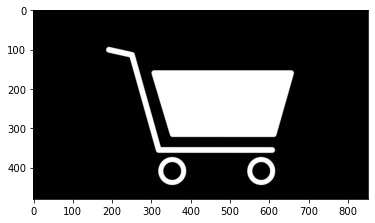

In [48]:
#getting image for word cloud

urllib.request.urlretrieve("https://ak.picdn.net/shutterstock/videos/1006608868/thumb/7.jpg", "cart.jpg")
shopping_cart = np.array(Image.open("cart.jpg"))
plt.imshow(shopping_cart)

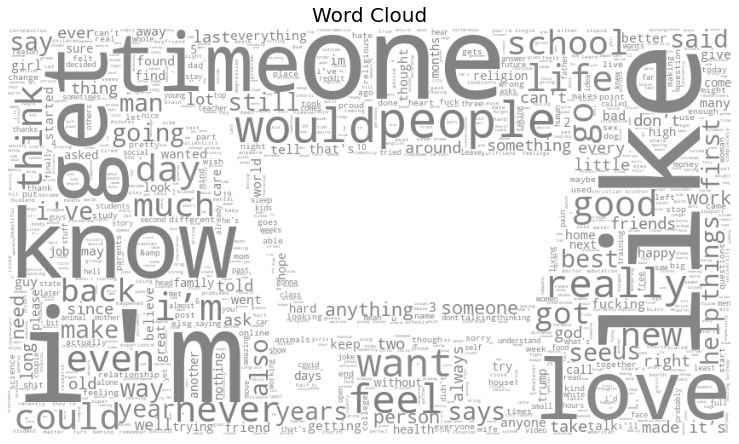

In [49]:
from wordcloud import WordCloud

def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,0%%, %d%%)" % np.random.randint(50,55))

stopwordCloud = set(stopwords.words("english"))

wordcloud = WordCloud(stopwords=stopwordCloud,max_words=1000,background_color="white",min_font_size=3,mask=shopping_cart).generate_from_frequencies(countedWordDict)
wordcloud.recolor(color_func = grey_color_func)
plt.figure(figsize=[13,10])
plt.axis("off")
plt.title("Word Cloud",fontsize=20)
plt.imshow(wordcloud)
plt.show()

In [51]:
#getting 'Text' as a list
textList = list(df['Text'])

In [60]:
#Preparing y
le = LabelEncoder()
labelEncode = le.fit_transform(data["topic"])
print("LabelEncode")
print(labelEncode)
categorical_y = to_categorical(labelEncode)
print("To_Categorical")
print(categorical_y)

LabelEncode
[7 6 4 ... 2 7 7]
To_Categorical
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [61]:
#preparing x for ANN
tfidv = TfidfVectorizer(max_features=20001)
x = tfidv.fit_transform(textList)
x.sort_indices()

x_train,x_test,y_train,y_test = train_test_split(x,categorical_y,test_size=0.33,random_state=42)


In [62]:
#Defining a basic Neural Network
def build_ann_model():
    model = Sequential()
    
    model.add(Dense(units=1024,activation="relu",input_dim=x_train.shape[1]))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=y_train.shape[1],activation="softmax"))
    
    optimizer = Adam(lr=0.000015,beta_1=0.9,beta_2=0.999)
    
    model.compile(optimizer=optimizer,metrics=["accuracy"],loss=categorical_crossentropy)
    return model

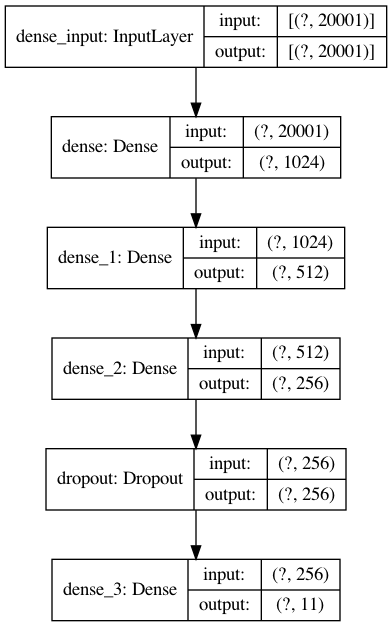

In [63]:
#Model layout
ann_model = build_ann_model()
plot_model(ann_model,show_shapes=True)

In [64]:
ann_history = ann_model.fit(x_train,y_train,epochs=20,batch_size=256,shuffle=True)
ypred = ann_model.predict(x_test)

Epoch 1/20
83/83 [==============================] - 9s 111ms/step - loss: 2.3958 - accuracy: 0.1242
Epoch 2/20
83/83 [==============================] - 9s 110ms/step - loss: 2.3882 - accuracy: 0.1465
Epoch 3/20
83/83 [==============================] - 9s 107ms/step - loss: 2.3729 - accuracy: 0.1471
Epoch 4/20
83/83 [==============================] - 9s 107ms/step - loss: 2.3424 - accuracy: 0.1603
Epoch 5/20
83/83 [==============================] - 9s 107ms/step - loss: 2.2901 - accuracy: 0.2091
Epoch 6/20
83/83 [==============================] - 9s 108ms/step - loss: 2.2092 - accuracy: 0.2617
Epoch 7/20
83/83 [==============================] - 9s 113ms/step - loss: 2.0996 - accuracy: 0.3298
Epoch 8/20
83/83 [==============================] - 10s 117ms/step - loss: 1.9675 - accuracy: 0.4311
Epoch 9/20
83/83 [==============================] - 9s 111ms/step - loss: 1.8221 - accuracy: 0.5344
Epoch 10/20
83/83 [==============================] - 10s 116ms/step - loss: 1.6773 - accuracy: 0.60

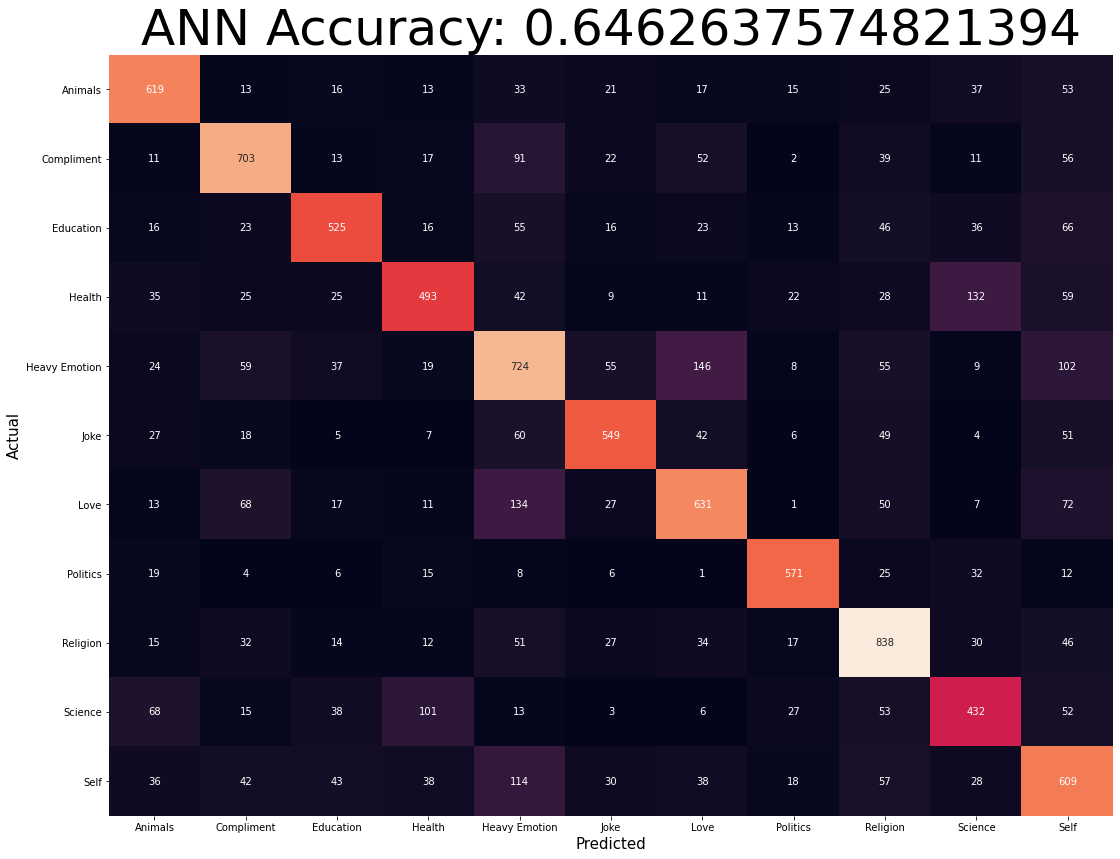

In [67]:
ann_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
#print("ANN Accuracy:",ann_accuracy)
ann_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(ann_cn,annot=True,fmt="1d",cbar=False,xticklabels=le.classes_,yticklabels=le.classes_)
plt.title("ANN Accuracy: {}".format(ann_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

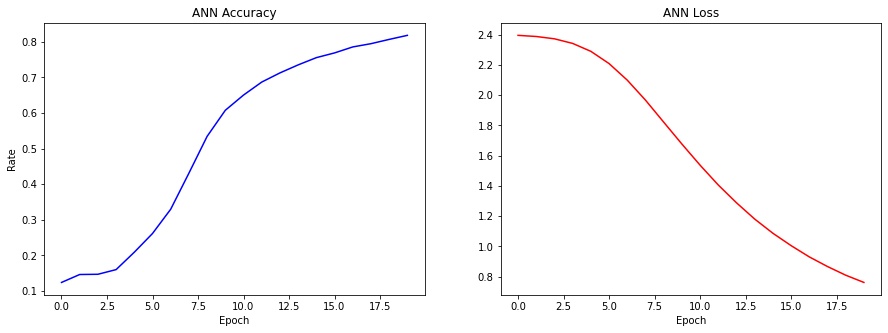

In [68]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(ann_history.history["accuracy"],label="accuracy",color="blue")
axe1[1].plot(ann_history.history["loss"],label="loss",color="red")
axe1[0].title.set_text("ANN Accuracy")
axe1[1].title.set_text("ANN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()